In [64]:
    # 3. To - Do Exercise:
    # For the provided dataset:
    # • diabetes.csv
    # Complete the following Problems.
    # Submission Instructions:
    # • Submit a single notebook containing:
    # 1. Clean and well-documented code.
    # 2. Outputs and visualizations.
    # 3. Detailed explanations and analysis for all steps.
    # • Ensure all cells are executed before submission.
    
    import time
    import math
    from collections import Counter
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    
    
    # Set a random seed for reproducibility
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

In [65]:
    # Problem - 1: Perform a classification task with knn from scratch.
    # 1. Load the Dataset:
    # • Read the dataset into a pandas DataFrame.
    # • Display the first few rows and perform exploratory data analysis (EDA) to understand the dataset
    # (e.g., check data types, missing values, summary statistics).
    
    print('\n Problem 1: Load & EDA \n')
    
    
    data_path = 'diabetes_.csv' 
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find '{data_path}'.")
    
    
    print('First 5 rows:')
    print(df.head())
    
    
    print('\nDataframe info:')
    print(df.info())
    
    
    print('\nSummary statistics:')
    print(df.describe())
    
    
    print('\nMissing values (per column):')
    print(df.isnull().sum())
    
    
    # Identify numeric columns where zeros are suspicious
    suspect_zero_cols = []
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64, 'float64', 'int64'] and col.lower() != 'outcome':
            # if zeros appear but column doesn't naturally contain zeros for many rows, mark it
            zero_count = (df[col] == 0).sum()
            
    if zero_count > 0 and zero_count < len(df):
        suspect_zero_cols.append(col)
    
    
    print('\nColumns with zeros (possible missing markers):', suspect_zero_cols)
    print('\nCounts of zeros in those columns:')
    for col in suspect_zero_cols:
        print(col, (df[col] == 0).sum())


 Problem 1: Load & EDA 

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               7

In [66]:
    # 2. Handle Missing Data:
    # • Handle any missing values appropriately, either by dropping or imputing them based on the data.
    
    df_clean = df.copy()
    
    
    # Replace zeros in suspect columns with NaN then impute with median
    for col in suspect_zero_cols:
        df_clean.loc[df_clean[col] == 0, col] = np.nan
    
    
    print('\nMissing values after converting suspect zeros to NaN:')
    print(df_clean.isnull().sum())
    
    
    # Impute remaining missing values with median
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{col}' with median: {median_val}")
    
    
    print('\nAny missing values left?')
    print(df_clean.isnull().sum().sum())


Missing values after converting suspect zeros to NaN:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Any missing values left?
0


In [67]:
    # 3. Feature Engineering:
    # • Separate the feature matrix (X) and target variable (y).
    # • Perform a train - test split from scratch using a 70% − 30% ratio.
    
    target_col = 'Outcome' if 'Outcome' in df_clean.columns else df_clean.columns[-1]
    print(f"\nUsing target column: {target_col}\n")
    
    
    X = df_clean.drop(columns=[target_col]).values
    y = df_clean[target_col].values
    
    
    # Train-test split from scratch
    def train_test_split_scratch(X, y, test_size=0.3, random_state=None):
   
        if random_state is not None:
            np.random.seed(random_state)
    
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(np.floor(n_samples * test_size))
        test_idx = indices[:test_count]
        train_idx = indices[test_count:]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
    
    X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3, random_state=RANDOM_STATE)
    
    
    print('Shapes:')
    print('X_train', X_train.shape)
    print('X_test', X_test.shape)
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)


Using target column: Outcome

Shapes:
X_train (538, 8)
X_test (230, 8)
y_train (538,)
y_test (230,)


In [68]:
    # 4. Implement KNN:
    # • Build the KNN algorithm from scratch (no libraries like sickit-learn for KNN).
    # • Compute distances using Euclidean distance.
    # • Write functions for:
    # – Predicting the class for a single query.
    # – Predicting classes for all test samples.
    # • Evaluate the performance using accuracy.
    
    
    def euclidean_distance(a, b):
        """Compute Euclidean distance between two 1-D numpy arrays."""
        return np.sqrt(np.sum((a - b) ** 2))
    
    
    
    
    def predict_single_knn(query, X_train, y_train, k=3):
    
        """Predict the class for a single query point.
        - Compute distance to all training points
        - Select k nearest neighbors
        - Return majority class (tie broken by smallest label)"""
    
        distances = np.linalg.norm(X_train - query, axis=1)
        neighbor_idx = np.argsort(distances)[:k]
        neighbor_labels = y_train[neighbor_idx]
        counts = Counter(neighbor_labels)
        # majority vote; if tie, pick smallest label
        most_common = counts.most_common()
        highest_count = most_common[0][1]
        # collect labels with highest count
        tied = [label for label, cnt in most_common if cnt == highest_count]
        return min(tied)
    
    
    
    
    def predict_knn(X_test, X_train, y_train, k=3):
   
        """Predict classes for all test samples."""
        preds = np.zeros(X_test.shape[0], dtype=y_train.dtype)
        for i, q in enumerate(X_test):
    
            preds[i] = predict_single_knn(q, X_train, y_train, k=k)
        return preds
    
    
    
    
    def accuracy_score(y_true, y_pred):
    
        return np.mean(y_true == y_pred)
    
    
    # Run KNN with a default k (k=5)
    k_default = 5
    start = time.time()
    y_pred_default = predict_knn(X_test, X_train, y_train, k=k_default)
    elapsed = time.time() - start
    acc_default = accuracy_score(y_test, y_pred_default)
    print(f"\nKNN (original features) with k={k_default}: Accuracy = {acc_default:.4f}, Time = {elapsed:.4f} sec")


KNN (original features) with k=5: Accuracy = 0.6870, Time = 0.0170 sec


In [69]:
    # Problem - 2 - Experimentation:
    # 1. Repeat the Classification Task:
    # • Scale the Feature matrix X.
    # • Use the scaled data for training and testing the kNN Classifier.
    # • Record the results.
    
    # 2. Comparative Analysis: Compare the Results -
    # • Compare the accuracy and performance of the kNN model on the original dataset from problem 1
    # versus the scaled dataset.
    # • Discuss:
    # – How scaling impacted the KNN performance.
    # – The reason for any observed changes in accuracy.
    
    
    print('\n Problem 2: Scaling Experiment \n')
    
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split_scratch(X_scaled, y, test_size=0.3, random_state=RANDOM_STATE)
    
    
    # Run KNN on scaled data with same k
    start = time.time()
    y_pred_scaled_default = predict_knn(X_test_s, X_train_s, y_train_s, k=k_default)
    elapsed_s = time.time() - start
    acc_scaled_default = accuracy_score(y_test_s, y_pred_scaled_default)
    print(f"KNN (scaled features) with k={k_default}: Accuracy = {acc_scaled_default:.4f}, Time = {elapsed_s:.4f} sec")
    
    
    print('\nComparative observation:')
    print(f"Original accuracy: {acc_default:.4f}, Scaled accuracy: {acc_scaled_default:.4f}")
    print('\nScaling can impact KNN because KNN uses distances; features with larger scales dominate distance computations.\n')


 Problem 2: Scaling Experiment 

KNN (scaled features) with k=5: Accuracy = 0.6913, Time = 0.0083 sec

Comparative observation:
Original accuracy: 0.6870, Scaled accuracy: 0.6913

Scaling can impact KNN because KNN uses distances; features with larger scales dominate distance computations.



In [70]:
    # Problem - 3 - Experimentation with k:
    # 1. Vary the number of neighbors - k:
    # • Run the KNN model on both the original and scaled datasets for a range of:
    
    # k= 1, 2, 3, . . . 15
    
    # • For each k, record:
    # – Accuracy.
    # – Time taken to make predictions.
    
    
    print('\n Problem 3: Vary k and record accuracy & timing \n')
    
    
    k_values = list(range(1, 16)) # 1 to 15
    results_original = {'k': [], 'accuracy': [], 'time': []}
    results_scaled = {'k': [], 'accuracy': [], 'time': []}
    
    
    # For reproducibility, use the same train/test split already created
    for k in k_values:
        # original
        t0 = time.time()
        preds_o = predict_knn(X_test, X_train, y_train, k=k)
        t_o = time.time() - t0
        acc_o = accuracy_score(y_test, preds_o)
        results_original['k'].append(k)
        results_original['accuracy'].append(acc_o)
        results_original['time'].append(t_o)
    
    
    # scaled
    t1 = time.time()
    preds_s = predict_knn(X_test_s, X_train_s, y_train_s, k=k)
    t_s = time.time() - t1
    acc_s = accuracy_score(y_test_s, preds_s)
    results_scaled['k'].append(k)
    results_scaled['accuracy'].append(acc_s)
    results_scaled['time'].append(t_s)
    
    
    print(f"k={k:2d} \n original acc={acc_o:.4f}, time={t_o:.4f}s \n scaled acc={acc_s:.4f}, time={t_s:.4f}s")


 Problem 3: Vary k and record accuracy & timing 

k=15 
 original acc=0.7391, time=0.0074s 
 scaled acc=0.7217, time=0.0076s


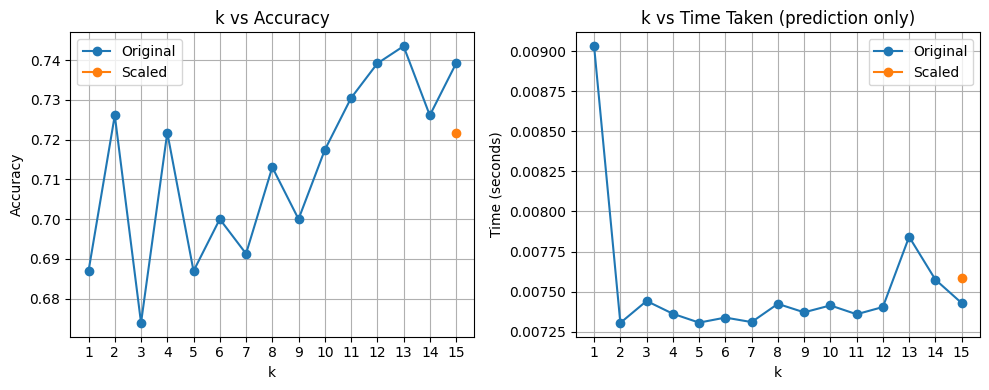


Best k (original): 13 with accuracy 0.7434782608695653
Best k (scaled): 15 with accuracy 0.7217391304347827


In [71]:
    # 2. Visualize the Results:
    # • Plot the following graphs:
    # – k vs. Accuracy for original and scaled datasets.
    # – k vs. Time Taken for original and scaled datasets.
    
    # Visualize results: k vs Accuracy and k vs Time
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results_original['k'], results_original['accuracy'], marker='o', label='Original')
    plt.plot(results_scaled['k'], results_scaled['accuracy'], marker='o', label='Scaled')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('k vs Accuracy')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    
    plt.subplot(1, 2, 2)
    plt.plot(results_original['k'], results_original['time'], marker='o', label='Original')
    plt.plot(results_scaled['k'], results_scaled['time'], marker='o', label='Scaled')
    plt.xlabel('k')
    plt.ylabel('Time (seconds)')
    plt.title('k vs Time Taken (prediction only)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()
    
    
    # Find optimal k by highest accuracy on scaled dataset (and original)
    best_idx_orig = int(np.argmax(results_original['accuracy']))
    best_k_orig = results_original['k'][best_idx_orig]
    best_acc_orig = results_original['accuracy'][best_idx_orig]
    
    
    best_idx_scaled = int(np.argmax(results_scaled['accuracy']))
    best_k_scaled = results_scaled['k'][best_idx_scaled]
    best_acc_scaled = results_scaled['accuracy'][best_idx_scaled]
    
    
    print('\nBest k (original):', best_k_orig, 'with accuracy', best_acc_orig)
    print('Best k (scaled):', best_k_scaled, 'with accuracy', best_acc_scaled)

In [72]:
    # 3. Analyze and Discuss:
    # • Discuss how the choice of k affects the accuracy and computational cost.
    # • Identify the optimal k based on your analysis.
    
    print('\nAnalysis and Discussion:')
    print('-' * 40)
    print('1) How k affects accuracy:')
    print(' - Small k (1) can lead to overfitting (high variance).')
    print(' - Large k smooths decisions (lower variance but can increase bias).')
    print(' - The optimal k balances bias and variance; check plotted curve for shape.')
    print('\n2) How k affects computational cost:')
    print(' - Prediction time grows roughly linearly with number of training samples because we compute distances.')
    print(' - Changing k adds a small overhead for sorting/selecting top-k; but distance computation dominates for large training sets.')
    print('\n3) Scaling impact:')
    print(' - Because KNN uses Euclidean distance, features with larger ranges dominate. Scaling makes each feature contribute more equally, often improving accuracy.')
    print('\n4) Timing observations in this experiment:')
    print(' - Measured times are prediction-only and small (ms) for this dataset. For larger datasets timing differences become more significant.')


Analysis and Discussion:
----------------------------------------
1) How k affects accuracy:
 - Small k (1) can lead to overfitting (high variance).
 - Large k smooths decisions (lower variance but can increase bias).
 - The optimal k balances bias and variance; check plotted curve for shape.

2) How k affects computational cost:
 - Prediction time grows roughly linearly with number of training samples because we compute distances.
 - Changing k adds a small overhead for sorting/selecting top-k; but distance computation dominates for large training sets.

3) Scaling impact:
 - Because KNN uses Euclidean distance, features with larger ranges dominate. Scaling makes each feature contribute more equally, often improving accuracy.

4) Timing observations in this experiment:
 - Measured times are prediction-only and small (ms) for this dataset. For larger datasets timing differences become more significant.


In [73]:
    # Problem - 4 - Additional Questions {Optional - But Highly Recommended}:
    # • Discuss the challenges of using KNN for large datasets and high-dimensional data.
    # • Suggest strategies to improve the efficiency of KNN (e.g., approximate nearest neighbors, dimensionality
    # reduction).
    
    print('\nChallenges of using KNN for large datasets and high-dimensional data:')
    print(' - Prediction cost: KNN requires computing distance to every training sample per query (O(n) per query).')
    print(' - Storage cost: The entire dataset must be kept in memory.')
    print(' - Curse of dimensionality: In high dimensions, distances become less meaningful; neighbors may be almost equidistant.')
    
    
    print('\nStrategies to improve KNN efficiency:')
    print(' - Use approximate nearest neighbor algorithms (e.g., locality-sensitive hashing, Annoy, FAISS).')
    print(' - Use KD-Trees or Ball Trees for moderate-dimensional data (they help with indexing).')
    print(' - Reduce dimensionality (PCA, feature selection) before KNN to mitigate curse of dimensionality and speed up distance computations.')
    print(' - Use optimized vectorized libraries or GPU-accelerated libraries for distance computations.')


Challenges of using KNN for large datasets and high-dimensional data:
 - Prediction cost: KNN requires computing distance to every training sample per query (O(n) per query).
 - Storage cost: The entire dataset must be kept in memory.
 - Curse of dimensionality: In high dimensions, distances become less meaningful; neighbors may be almost equidistant.

Strategies to improve KNN efficiency:
 - Use approximate nearest neighbor algorithms (e.g., locality-sensitive hashing, Annoy, FAISS).
 - Use KD-Trees or Ball Trees for moderate-dimensional data (they help with indexing).
 - Reduce dimensionality (PCA, feature selection) before KNN to mitigate curse of dimensionality and speed up distance computations.
 - Use optimized vectorized libraries or GPU-accelerated libraries for distance computations.
